%%latex
\tableofcontents

%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

# Introduction

This project deals with the problem of object tracking in a static-background environment. The goal is to find and track objects in a video sequence. The methods used are based on the work of Nummiaro et al. \cite{nummiaro2002}, where applying colour distributions, make the model more robust to brief and partial occlusion, rotation, and scale changes, especially efficient and useful in the case of single-target tracking.
The videos used in this project are from the MOT17 challenge dataset \cite{mot17}, available [here](https://motchallenge.net/data/MOT17/).


In [1]:
# general
from src.utils import *
import os
import time
# computation and vision
import cv2
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
names = ['MOT17-09-DPM-raw']
videos = {}
for name in names:
    videos[name] = load_video('./MOT/'+name+'.mp4', show=False, f=1)


# Particle-Filter Tracking

This method, based on the work *An Adaptive Colour-Based Particle Filter* \cite{nummiaro2002}, and follows a top-down approach, where it generates object hypotheses and attempts to verify them with the data. Using the colour distributions, this method only attempts to match only objects that have a similar histogram and build on top of particle filtering.

## Definition
Particle filtering tracks the state of an object described by a vector $X_t$ while an observation vector $Z_t$ keeps track of all observations up to time $t$. These filters are often used for non-Gaussian posterior density $p(X_t|Z_t)$ and observation density $p(z_t|X_t)$. The key idea is approximating the probability distribution by a weighted samples set $S$ where each sample denotes a hypothetical state of the object with a discrete sampling probability distribution $\pi$.

The sample set evolves by propagating each sample according to a model, then each element is weighted in terms of observation and $N$ samples are drawn by choosing a particular sample with probabily $\pi^{(n)} = p(z_t|X_t = s_t^{(n)}).$ The mean state of an object is estimated at each time $t$ by:
$$ E[S] = \sum_{n=1}^{N}{\pi^{(n)}s^{(n)}}$$

By modelling uncertainty, the model keeps the options open and can consider multiple hypotheses and choose the closest. By keeping the less likely states in memory briefly, the model can deal with short-term occlusion.

### Colour Distribution
The colour distribution are used to provide robustness to non-rigidity, rotation, scaling, and partial occlusion. By discretizing the distributions into $m$ bins, histograms produced are produced in HSV colour space to allow for less sensitivity to illumination changes (fewer bins in the V channel). The distribution is determined inside an upright elliptic region with half axes $H_x$ and $H_y$. Smaller weights are assigned to pixels farther from the centre of the region using a weighting function.
$$k(r) = \left \{ \begin{array}{ccl}1-r^2 & r < 1 \\ 0 & otherwise \end{array}\right.$$
where $r$ is the distance from the centre of the region.

The colour distribution $p_y = {p_y^{(u)}}_{u=1..m}$ is defined as:
$$p_y^{(u)} = f \sum_{i=1}^{I}{k(\frac{||y-x_i||}{a})\delta[h(x_i) - u]}$$
where $f$ is the normalization factor, $I$ is the number of pixels in region, $\delta$ is the Kronecker delta function, and $a=\sqrt{H_x^2+H_y^2}$.

Considering the colour histograms $p$ and $q$, the similarity measure is defined using Bhattacharyya coefficient:
$$\rho[p,q] = \sum_{u=1}^{m}{\sqrt{p^{(u)}q^{(u)}}}$$
and hence the Bhattacharyya distance, which updates the a priori distribution given by particle filter, is:
$$d[p,q] = \sqrt{1-\rho[p,q]}$$


Each sample in the distribution represents an ellipse given by $state = {x, y, \dot{x}, \dot{y}, H_x, H_y, \dot{a}}$, where $(x,y)$ is the coordinate of the central point, $(H_x, H_y)$ are the half axes, $(\dot{x}, \dot{y})$ is the motion, and $\dot{a}$ is the scale change.
The sample set is then propagated using:
$$s_t = A s_{t-1} + w_{t-1}$$
where $A$ defines the deterministic component of the model and $w_{t-1}$ is a multivariate Gaussian random variable.

## Algorithm and Implementation
The Particle Filter model is first initialised with a set of samples placed inside the initial location of the target and the colour distribution is calculated for the first frame.
Each consequent iteration has four steps:
1. **Select**: selects $N$ samples from set $S_{t-1}$ with probability $\pi_{t-1}^{(n)}$.
2. **Propagate**: propagates each sample from set $S'_{t-1}$ by the equation given above.
3. **Observe**: observes the colour distributions using the method described.
4. **Estimate**: estimates the mean state of $S_t$.
Generated outputs are saved in the form of jpg images and stitched together using ffmpeg to create the output video.

### Performance Optimisations
The main parameter —aside from initial set— is the number of particles. For a low number of particles, the model might 'wander' incorrectly, but for a high number of particles, the model might be too slow to track the target.
To increase the speed of the algorithm, a third-size video, sliced to three seconds, is used from the MOT17 dataset \cite{MOT17}. The generated outputs are for the woman in green (right side of the image) for `particle_count` $\in [10, 50, 80]$ and the man in black (starting on the left side) with `particle_count` $ = [20, 30]$, to display its performance on occlusion.

In [3]:
from src.utils import *
from src.ParticleFilter import ParticleFilter

In [4]:
name = 'MOT17-09-DPM-raw'
sframe = 50
eframe = 200
p_count = 20
target = 'man_black'
# get_points(videos[name][sframe])

In [5]:
frames = np.copy(videos[name][sframe:eframe])
PF = ParticleFilter(frames, particle_count=p_count, init_x=77, init_y=93, init_Hx=17, init_Hy=35, out_path='./output/')

In [7]:
# pf_df = pd.DataFrame(columns=['Test', 'Time', 'Particle Count'])
# or import from file
pf_df = pd.read_csv('./output/pf_df.csv')

In [ ]:
start = time.time()
while PF.f_idx < len(PF.frames) - 1:
    PF.select()
    PF.propagate()
    PF.observe()
    PF.estimate()
pf_time = time.time() - start

In [ ]:
pf_df.loc[len(pf_df)] = [(name+'-'+target), pf_time, len(PF.particles)]
pf_df.to_csv('./output/pf_df.csv', index=False)

In [12]:
save_output(output_name=f'{name}_{PF.particle_count}_{target}.mp4')

0

## Results
For the `woman_green` target tests, the optimal particle count is 50, since 10 particles has reduced accuracy, while 80 particles is both slow and more prone to scale changes (the final frames only track a limb).

In [8]:
pf_df

,Test,Time,Particle Count
0,MOT17-09-DPM-raw-woman_green,2087.318851,50
1,MOT17-09-DPM-raw-woman_green,496.561201,10
2,MOT17-09-DPM-raw-woman_green,3197.979189,80
3,MOT17-09-DPM-raw-man_black,3441.367042,30
4,MOT17-09-DPM-raw-man_black,3487.032923,20


# Kalman Filter Tracking

Kalman filters are a much lighter method of tracking than particle filters and can be used in real-time applications. They are optimal for linear systems with Gaussian noise. 

## Definition
A Kalman filter consists of two basic steps:
1. **Prediction (Time Update)**: predicts the state of the object at the next time step.
2. **Correction (Measurement Update)**: corrects the state of the object using the measurement.

In each iteration at time $k-1$, a new best estimate is predicted from a previous best estimate plus a correction based on *known* external ingluence, while the new uncertainty is predicted from the old uncertainty and an additional noise from the environment\cite{Babb2015}.
Combining the two Gaussian blobs will yield Kalman gain $\mathbf{K}$.
Given state estimation $\mathbf{\hat{x}}_k$, sensor model $\mathbf{H}_k$, sensor noise (uncertainty) $\mathbf{R}$, and the prediction matrix $\mathbf{P}_k$, the equations for update state will be:
$$\mathbf{\hat{x}}'_k = \mathbf{\hat{x}}_k + \mathbf{K} (z_k - \mathbf{H} \mathbf{\hat{x}}_k)$$

$$\mathbf{P}'_k = (I - \mathbf{K}' \mathbf{H}) \mathbf{P}_k$$

$$\mathbf{K'} = \mathbf{P}_k \mathbf{H}_k^T (\mathbf{H}_k \mathbf{P}_k \mathbf{H}_k^T + \mathbf{R})^{-1}$$



## Implementation
To better distinguish moving parts from the background, the background is first estimated by a 30-frame sample of the frames, smoothed using homographic operations, and subtracted from each frame. Kalman filtering can be then done on the foreground, usign a separate Kalman filter for each object that is being tracked (number of tracked objects is given by `obj_count` parameter).

This allows for multi-target object tracking, though the results are not as good as particle filters. 

In [9]:
from importlib import reload
import src.KalmanFilter
import src.utils
reload(src.KalmanFilter)
reload(src.utils)
from src.utils import *
from src.KalmanFilter import KalmanFilter

In [10]:
# kf_df = pd.DataFrame(columns=['Test', 'Time', 'Object Count'])
# or import from file
kf_df = pd.read_csv('./output/kf_df.csv')

In [36]:
name = 'MOT17-09-DPM-raw'
sframe = 0
eframe = 200

In [37]:
frames = np.copy(videos[name][sframe:eframe])
background = get_background(frames)
approx, sorted_contours = clean_frames(frames, background)

In [38]:
def kalman_pipeline(frames, approx, sorted_contours, object_cnt=1):
    KF_list = []
    prev_pred = [{} for i in range(object_cnt)]
    # get colours for each object
    cr_colours = get_index_cmap(object_cnt, 'autumn')
    pred_colours = get_index_cmap(object_cnt, 'winter')
    x_pos, y_pos = 0, 0
    for i in range(object_cnt):
        kf = KalmanFilter()
        KF_list.append(kf)
    for f_idx, f in enumerate(frames):
        for i in range(object_cnt):
            if i < len(sorted_contours):
                cx = sorted_contours[f_idx][i][1]
                x, y, w, h = cv2.boundingRect(cx)
                x_pos = x + w//2
                y_pos = y + h//2
                # current measurement
                zk = np.array([[x_pos], [y_pos]])
                xk, yk = zk
                # predict (time update)
                curr_predict = KF_list[i].predict()
                cpx = curr_predict[0]
                cpy = curr_predict[1]
                # correct (measurement update)
                KF_list[i].correct(zk)
                # draw the blobs
                cv2.circle(f, (int(xk), int(yk)), 20, cr_colours[i], 3)
                cv2.putText(f, "M" + str(i), (int(xk)-30, int(yk)-20), cv2.FONT_HERSHEY_SIMPLEX, 0.70, cr_colours[i], 2)
                cv2.circle(f, (int(cpx[0]), int(cpy[0])), 20, pred_colours[i], 2)
                cv2.putText(f, "P" + str(i), (int(cpx[0]-30), int(cpy[0]-20)), cv2.FONT_HERSHEY_SIMPLEX, 0.70, pred_colours[i], 2)
    return frames

In [42]:
over_frames = np.copy(frames)
object_cnt = 1
start = time.time()
outs = kalman_pipeline(over_frames, approx, sorted_contours, object_cnt=object_cnt)
kf_time = time.time() - start
kf_df.loc[len(kf_df)] = [f'{name}_{sframe}-{eframe}', kf_time, object_cnt]
kf_df.to_csv('./output/kf_df.csv', index=False)

In [43]:
for i, f in enumerate(outs):
    cv2.imwrite('./output/%04d.jpg'%(i + 1), f)
save_output(output_name=f'kalman_{name}_{sframe}-{eframe}_{object_cnt}.mp4')
# clear ./output/*.jpg
for filename in os.listdir('./output'):
    file_path = os.path.join('./output', filename)
    if os.path.isfile(file_path) and '.jpg' in filename:
        os.remove(file_path)

## Results

Due to the simplicity of inference, the Kalman filter is much faster than the particle filter and can be even performed online. The time-consuming part of the operations is the background extraction, which is done prior to reading the entire video (it can also be simulated by a calibration period on an online environment) and hence the main algorithm takes less than a 200 ms to iterate on the data in the most intensive case tested. 

In [139]:
kf_df

,Test,Time,Object Count
2,MOT17-09-DPM-raw_0-200,0.024998,1
1,MOT17-09-DPM-raw_0-150,0.035006,1
3,MOT17-09-DPM-raw_0-200,0.100172,3
0,MOT17-09-DPM-raw_0-150,0.185002,3


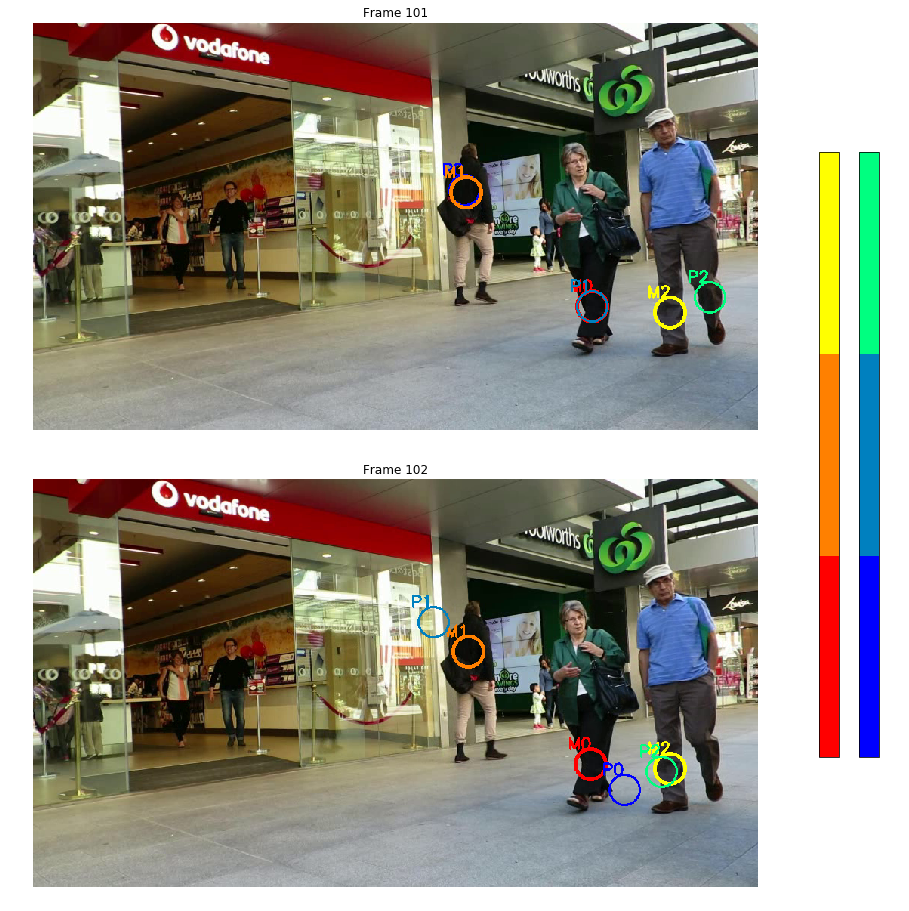

In [34]:
from matplotlib import cm
n = 100
plt.figure(figsize=(14, 12))
plt.subplot(211)
plt.imshow(cv2.cvtColor(outs[n], cv2.COLOR_BGR2RGB))
plt.title(f'Frame {n+1}')
plt.axis('off')

plt.subplot(212)
plt.imshow(cv2.cvtColor(outs[n+1], cv2.COLOR_BGR2RGB))
plt.title(f'Frame {n+2}')
plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.12, top=1, bottom=0, left=0, right=1)
cax = plt.axes([0.96, 0.15, 0.02, 0.7])
scmap = cm.ScalarMappable(cmap=cm.get_cmap('winter', lut=object_cnt), norm=plt.Normalize(vmin=0, vmax=object_cnt))
scmap.set_array([])
plt.colorbar(cax=cax, mappable=scmap)
plt.axis('off')

cax = plt.axes([0.92, 0.15, 0.02, 0.7])
scmap = cm.ScalarMappable(cmap=cm.get_cmap('autumn', lut=object_cnt), norm=plt.Normalize(vmin=0, vmax=object_cnt))
scmap.set_array([])
plt.colorbar(cax=cax, mappable=scmap)
plt.axis('off')

# plt.savefig('./output/kalman_colourbars.png')
plt.show()

Above is the image of two consecutive frames, where the warmer colours (indicated by the left colourbar) are the measurements (centre of the circles are the centres of Gaussian blobs, i.e. the likeliest state) and the cooler colours (right colourbar) are the corresponding predictions performed before the correction step.

In the first frame, the predictions and measurements are acceptable close, although a major error exists: the predicted blob for the next movement of target 1 is actually the measurement of target 0 and vice versa. This is the challenge faced in multi-target tracking, as it can accidentally mix up the targets.

This algorithm can be described to be more robust to occlusion, as seen in the test with 3 targets and 0-200 frames, although it faces the problem of mixing up the targets, it does not entirely lose track of the object after emerging from occlusion (which happened with particle filtering on long-term occlusions of a moving scene).

The case with single-object tracking proves to be 'bouncy' in a moving multi-object scene. The Gaussian blobs jump to the most likely moving part of the scene, causing rapid change in the location of the blobs and appearing to track all three targets at once (see the outputs for 1 target). This case proves harder for occlusion management, though it might also be due to the crowding in the other side of the image.

In [44]:
for i, f in enumerate(outs):
    cv2.imshow('out', f)
    # cv2.imshow('approx', approx[i])
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

# References

(<a id="cit-nummiaro2002" href="#call-nummiaro2002">Nummiaro, Koller-Meier <em>et al.</em>, 2002</a>) Nummiaro Katja, Koller-Meier Esther and Van Gool Luc, ``_An Adaptive Color-Based Particle Filter_'', Image and Vision Computing, vol. 21, number , pp. 99--110,  2002.

(<a id="cit-mot17" href="#call-mot17">Milan, Leal-Taix <em>et al.</em>, 2016</a>) Milan A., Leal-Taix L., Reid I. <em>et al.</em>, ``_MOT17: A Benchmark for Multi-Object Tracking_'', arXiv:1603.00831 [cs], vol. , number , pp. , March 2016.  [online](http://arxiv.org/abs/1603.00831)

(<a id="cit-MOT17" href="#call-MOT17">Milan, Leal-Taix <em>et al.</em>, 2016</a>) Milan A., Leal-Taix L., Reid I. <em>et al.</em>, ``_MOT17: A Benchmark for Multi-Object Tracking_'', arXiv:1603.00831 [cs], vol. , number , pp. , March 2016.  [online](http://arxiv.org/abs/1603.00831)

(<a id="cit-Babb2015" href="#call-Babb2015">Babb, 2015</a>) Tim Babb, ``_How a Kalman Filter Works, in Pictures_'', August 2015.  [online](https://bzarg.com/p/how-a-kalman-filter-works-in-pictures/)

